### 低开销编译器
DEAP在编译GP时使用了Python的默认编译器，但是Python默认编译器在编译GP时实际上速度较慢，因此我们可以考虑自行实现一个编译器来加速GP运算。更严格来说，应该是自行实现一个GP树的解析函数，从而降低编译的时间开销。

In [1]:
import time
import warnings

import numpy as np
from deap import base, creator, tools, gp
from deap.gp import PrimitiveTree, Primitive, Terminal

warnings.filterwarnings("ignore")

# 栈的经典应用，详见leetcode逆波兰表达式
def quick_evaluate(expr: PrimitiveTree, pset, data, prefix='ARG'):
    result = None
    stack = []
    for node in expr:
        stack.append((node, []))
        while len(stack[-1][1]) == stack[-1][0].arity:
            prim, args = stack.pop()
            if isinstance(prim, Primitive):
                result = pset.context[prim.name](*args)
            elif isinstance(prim, Terminal):
                if prefix in prim.name:
                    result = data[:, int(prim.name.replace(prefix, ''))]
                else:
                    result = prim.value
            else:
                raise Exception
            if len(stack) == 0:
                break  # 栈为空代表所有节点都已经被访问
            stack[-1][1].append(result)
    return result


# 符号回归
def evalSymbReg(individual, pset):
    # 使用numpy创建一个向量
    x = np.linspace(-10, 10, 100).reshape(-1, 1)

    # 评估生成的函数并计算MSE
    mse = np.mean((quick_evaluate(individual, pset, x) - x ** 2) ** 2)

    return (mse,)


# 创建个体和适应度函数
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [2]:
import random

# 定义函数集合和终端集合
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.negative, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))

# 定义遗传编程操作
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)

In [3]:
import numpy
from deap import algorithms

# 定义统计指标
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

# 使用默认算法
custom_compiler_time = []
for i in range(3):
    start = time.time()
    population = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    pop, log = algorithms.eaSimple(population=population,
                                   toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof,
                                   verbose=True)
    end = time.time()
    print('time:', end - start)
    print(str(hof[0]))
    custom_compiler_time.append(end - start)

   	      	                    fitness                    	                     size                     
   	      	-----------------------------------------------	----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std    	avg 	gen	max	min	nevals	std   
0  	100   	2418.41	0  	26131.2	1849.78	100   	2462.38	3.83	0  	7  	2  	100   	1.5624
1  	92    	2156.48	1  	6509.62	1849.78	92    	616.277	3.9 	1  	10 	2  	92    	1.62788
2  	92    	2088.3 	2  	5780.9 	1849.78	92    	383.649	4.17	2  	9  	2  	92    	1.55599
3  	96    	5255.65	3  	153712 	1849.78	96    	21254  	4.65	3  	11 	2  	96    	1.95128
4  	89    	142391 	4  	1.23222e+07	1849.78	89    	1.23218e+06	5.3 	4  	13 	2  	89    	1.90526
5  	89    	125796 	5  	1.18875e+07	1849.78	89    	1.18237e+06	5.26	5  	11 	2  	89    	1.75852
6  	90    	11231.5	6  	157909     	1849.78	90    	36181      	5.03	6  	12 	3  	90    	1.94142
7  	92    	16040.2	7  	158106     	1849.78	92    	43625.5    	4.61	7  	11 	3  

In [4]:
# 慢速评估
def evalSymbReg(individual, pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)

    # 使用numpy创建一个向量
    x = np.linspace(-10, 10, 100)

    # 评估生成的函数并计算MSE
    mse = np.mean((func(x) - x ** 2) ** 2)

    return (mse,)


toolbox.register("evaluate", evalSymbReg, pset=pset)

py_time = []
for i in range(3):
    start = time.time()
    population = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    pop, log = algorithms.eaSimple(population=population,
                                   toolbox=toolbox, cxpb=0.9, mutpb=0.1, ngen=10, stats=mstats, halloffame=hof,
                                   verbose=True)
    end = time.time()
    print('time:', end - start)
    py_time.append(end - start)

   	      	                          fitness                          	                      size                     
   	      	-----------------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max        	min	nevals	std        	avg 	gen	max	min	nevals	std    
0  	100   	119309	0  	1.17257e+07	0  	100   	1.16649e+06	3.97	0  	7  	2  	100   	1.63985
1  	89    	1986.56	1  	8325.39    	0  	89    	851.977    	4.08	1  	11 	2  	89    	1.95284
2  	94    	4916.05	2  	153712     	0  	94    	21278      	4.3 	2  	10 	2  	94    	2.14243
3  	97    	7837.99	3  	153712     	0  	97    	29495.4    	4.93	3  	14 	2  	97    	2.28585
4  	96    	4447.93	4  	155692     	0  	96    	21511.4    	5.68	4  	14 	2  	96    	2.84211
5  	90    	4436.47	5  	153712     	0  	90    	21408.3    	5.97	5  	14 	2  	90    	3.06416
6  	93    	11738.2	6  	153712     	0  	93    	38823.1    	5.67	6  	13 	3  	93    	2.72784
7  	99    	2715.7 	7  	153712     	0  	99   

下图展示了实验结果，从实验结果可以看出，自行实现的编译器在编译GP树时的速度要快于Python默认编译器。主要是因为自行实现的编译器基本没有额外开销，而Python默认编译器在编译时会进行一些额外的操作，因此速度较慢。

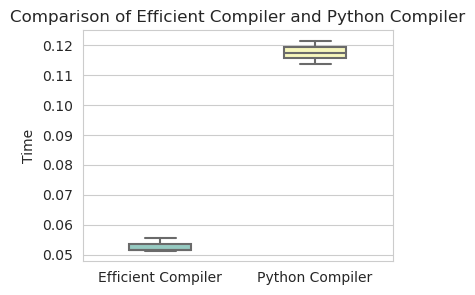

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = pd.DataFrame(
    {'Category': ['Efficient Compiler'] * len(custom_compiler_time) + ['Python Compiler'] * len(py_time),
     'Time': np.concatenate([custom_compiler_time, py_time])})

plt.figure(figsize=(4, 3))
sns.set_style("whitegrid")
sns.boxplot(data=data, x='Category', y='Time', palette="Set3", width=0.4)
plt.title('Comparison of Efficient Compiler and Python Compiler')
plt.xlabel('')
plt.ylabel('Time')
plt.show()